In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import cufflinks as cf
import plotly.offline as py
import warnings
warnings.simplefilter("ignore")
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LinearRegression, Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.metrics import r2_score,mean_squared_error,mean_squared_error

In [515]:
train_df=pd.read_csv(r"C:\Users\abhisv.CORP\3D Objects\Bigmart\train_v9rqX0R.csv")

In [516]:
train_df.shape

(8523, 12)

In [517]:
train_df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [518]:
print(len(train_df.columns))

12


In [519]:
cat=train_df.select_dtypes(include=['O'])
print(len(cat.columns))

7


In [520]:
numerical=train_df.select_dtypes(exclude=['O'])
print(len(numerical.columns))

5


In [521]:
train_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [522]:
cond=(train_df['Item_Weight'].isna())

In [523]:
len(cond[cond==True])

1463

In [524]:
train_df['Item_Identifier'].nunique()

1559

In [525]:
train_df.loc[cond,'Item_Identifier'].nunique()

1142

In [526]:
train_df.loc[cond,'Item_Weight']
map1=dict(train_df.groupby('Item_Identifier')['Item_Weight'].median())
map1
#pd.pivot_table('Item_Weight',index='Item_Identifier',aggfunc=np.mean())
train_df.loc[cond,'Item_Weight']=train_df.loc[cond,'Item_Identifier'].apply(lambda x :map1[x])

In [527]:
train_df.isna().sum()

Item_Identifier                 0
Item_Weight                     4
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [528]:
cond1=(train_df['Item_Weight'].isna())
cond1[cond1==True]

927     True
1922    True
4187    True
5022    True
Name: Item_Weight, dtype: bool

In [529]:
train_df['Item_Weight'].fillna(train_df['Item_Weight'].median(),inplace=True)

In [530]:
train_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.875314,0.066132,140.992782,1997.831867,2181.288914
std,4.645010,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026989,93.826500,1987.000000,834.247400
50%,12.650000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [531]:
train_df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [532]:
train_df['Outlet_Size']=train_df['Outlet_Size'].map({'Small':1,'Medium':2,'High':3})

In [533]:
null_loc=train_df[train_df['Outlet_Size'].isna()]['Outlet_Location_Type'].value_counts().index

In [534]:
null_loc

Index(['Tier 2', 'Tier 3'], dtype='object')

In [535]:
train_df[train_df['Outlet_Size'].isna()].groupby(['Outlet_Identifier'])['Outlet_Location_Type'].agg(pd.Series.mode)

Outlet_Identifier
OUT010    Tier 3
OUT017    Tier 2
OUT045    Tier 2
Name: Outlet_Location_Type, dtype: object

In [536]:
train_df.groupby(['Outlet_Location_Type'])['Outlet_Size'].agg(pd.Series.mode)

Outlet_Location_Type
Tier 1    1.0
Tier 2    1.0
Tier 3    2.0
Name: Outlet_Size, dtype: float64

In [537]:
train_df.groupby(['Outlet_Type'])['Outlet_Size'].agg(pd.Series.mode)

Outlet_Type
Grocery Store        1.0
Supermarket Type1    1.0
Supermarket Type2    2.0
Supermarket Type3    2.0
Name: Outlet_Size, dtype: float64

In [538]:
train_df[train_df['Outlet_Size'].isna()].groupby(['Outlet_Identifier'])['Outlet_Type'].agg(pd.Series.mode)

Outlet_Identifier
OUT010        Grocery Store
OUT017    Supermarket Type1
OUT045    Supermarket Type1
Name: Outlet_Type, dtype: object

In [539]:
cond=(train_df['Outlet_Size'].isna())
train_df.loc[cond & (train_df['Outlet_Identifier']=='OUT010') & (train_df['Outlet_Type']=='Grocery Store'),'Outlet_Size']=1
train_df.loc[cond & (train_df['Outlet_Identifier']=='OUT045') & (train_df['Outlet_Type']=='Supermarket Type1'),'Outlet_Size']=1
train_df.loc[cond & (train_df['Outlet_Identifier']=='OUT017') & (train_df['Outlet_Type']=='Supermarket Type1'),'Outlet_Size']=1

In [540]:
train_df['Outlet_Size'].isna().sum()

0

In [541]:
train_df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [542]:
train_df['Outlet_Type']=train_df['Outlet_Type'].map({'Grocery Store':1,'Supermarket Type1':2,'Supermarket Type2':3,'Supermarket Type3':4})

In [543]:
train_df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [544]:
train_df['Outlet_Location_Type']=train_df['Outlet_Location_Type'].map({'Tier 1':1,'Tier 2':2,'Tier 3':3})

In [545]:
train_df.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,2.0,1,2,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,2.0,3,3,443.4228


In [546]:
groupby_ios=train_df.groupby('Item_Identifier')['Item_Outlet_Sales'].sum().sort_values(ascending=False).reset_index().head(20)

In [547]:
groupby_ios['Item_Outlet_Sales'].median(),groupby_ios['Item_Outlet_Sales'].mean()

(32596.569300000003, 34007.66582)

In [548]:
groupby_ios

,Item_Identifier,Item_Outlet_Sales
0,FDY55,42661.8008
1,FDA15,41584.5364
2,FDZ20,40185.0248
3,FDF05,36555.7490
4,FDA04,35741.4756
5,FDK03,34843.9772
6,NCQ06,34680.1904
7,NCQ53,34508.4140
8,FDJ55,33531.0196
9,FDD44,32723.4042


In [549]:
groupby_ios['Item_Identifier'].shape[0]

20

In [550]:
train_df['Item_Identifier'].shape[0]

8523

In [551]:
train_df['Item_Identifier']=pd.DataFrame(groupby_ios['Item_Identifier'].sample(8523,replace=True)).reset_index(drop=True)

In [552]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDQ52,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,2.0,1,2,3735.1380
1,FDO37,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,2.0,3,3,443.4228
2,FDT07,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,2.0,1,2,2097.2700
3,FDQ52,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,1.0,3,1,732.3800
4,FDF05,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,3.0,3,2,994.7052


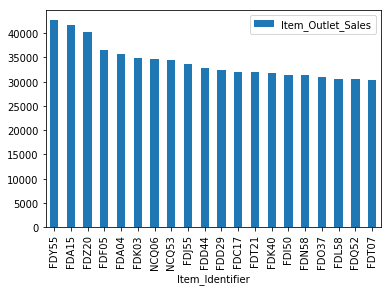

In [553]:
groupby_ios.plot(x='Item_Identifier',y='Item_Outlet_Sales',kind='bar',subplots=False)

In [557]:
le=LabelEncoder()
le.fit(train_df['Item_Identifier'])
le_ii=le.transform(train_df['Item_Identifier'])

In [562]:
le_ii=pd.DataFrame(le_ii)

In [563]:
le_ii.rename(columns={0:'Item_Identifier'},inplace=True)

In [564]:
train_df.drop('Item_Identifier',axis=1,inplace=True)

In [565]:
train_df=pd.concat([train_df,le_ii],axis=1)

In [568]:
cat.drop('Item_Identifier',axis=1,inplace=True)

In [569]:
cat_dummy=pd.get_dummies(cat,drop_first=True)

In [570]:
train_df.drop(cat,axis=1,inplace=True)

In [571]:
train_df=pd.concat([train_df,cat_dummy],axis=1)

In [572]:
train_df.shape

(8523, 41)

In [573]:
Y=train_df['Item_Outlet_Sales']
Y=pd.DataFrame(Y)

In [574]:
train_df.drop('Item_Outlet_Sales',axis=1,inplace=True)

In [575]:
X=train_df

In [576]:
rfc=RandomForestRegressor()
rfc.fit(X,Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [577]:
rfc.predict(X)

array([4207.98916,  585.77084, 2084.81954, ..., 1378.8718 , 1518.95612,
        974.46488])

In [578]:
accuracy=r2_score(Y,rfc.predict(X))
accuracy

0.9191680348798331

In [579]:
test_df=pd.read_csv(r"C:\Users\abhisv.CORP\3D Objects\Bigmart\test_AbJTz2l.csv")

In [580]:
cat=test_df.select_dtypes(include='O')

In [581]:
cat.head(2)

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,Low Fat,Snack Foods,OUT049,Medium,Tier 1,Supermarket Type1
1,FDW14,reg,Dairy,OUT017,NaN,Tier 2,Supermarket Type1


In [582]:
test_df.isna().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [583]:
cond=(test_df['Outlet_Size'].isna())
test_df.loc[cond & (test_df['Outlet_Identifier']=='OUT010') & (test_df['Outlet_Type']=='Grocery Store'),'Outlet_Size']=1
test_df.loc[cond & (test_df['Outlet_Identifier']=='OUT045') & (test_df['Outlet_Type']=='Supermarket Type1'),'Outlet_Size']=1
test_df.loc[cond & (test_df['Outlet_Identifier']=='OUT017') & (test_df['Outlet_Type']=='Supermarket Type1'),'Outlet_Size']=1

In [584]:
test_df.isna().sum()

Item_Identifier                0
Item_Weight                  976
Item_Fat_Content               0
Item_Visibility                0
Item_Type                      0
Item_MRP                       0
Outlet_Identifier              0
Outlet_Establishment_Year      0
Outlet_Size                    0
Outlet_Location_Type           0
Outlet_Type                    0
dtype: int64

In [585]:
cond=(test_df['Item_Weight'].isna())

In [586]:
test_df.loc[cond,'Item_Weight']
map1=dict(test_df.groupby('Item_Identifier')['Item_Weight'].median())
map1
#pd.pivot_table('Item_Weight',index='Item_Identifier',aggfunc=np.mean())
test_df.loc[cond,'Item_Weight']=test_df.loc[cond,'Item_Identifier'].apply(lambda x :map1[x])

In [587]:
test_df['Item_Identifier']=pd.DataFrame(groupby_ios['Item_Identifier'].sample(8523,replace=True)).reset_index(drop=True)

In [588]:
le=LabelEncoder()
le.fit(test_df['Item_Identifier'])
le_ii=le.transform(test_df['Item_Identifier'])

le_ii=pd.DataFrame(le_ii)

le_ii.rename(columns={0:'Item_Identifier'},inplace=True)

test_df.drop('Item_Identifier',axis=1,inplace=True)

test_df=pd.concat([test_df,le_ii],axis=1)
cat.drop('Item_Identifier',axis=1,inplace=True)
cat_dummy=pd.get_dummies(cat,drop_first=True)
test_df.drop(cat,axis=1,inplace=True)
test_df=pd.concat([test_df,cat_dummy],axis=1)

In [589]:
test_df.shape

(5681, 40)

In [592]:
test_df['Item_Weight'].fillna(test_df['Item_Weight'].median(),inplace=True)

In [593]:
rfc_test_predict=pd.DataFrame(rfc.predict(test_df))

In [595]:
rfc_test_predict.to_csv('sample_submission2.csv',index=False)